In [3]:
import pandas as pd
import scanpy as sc
%matplotlib notebook
%pylab

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [4]:
import pickle

## 1) Single cell analysis

In [5]:
import anndata

In [6]:
df = pd.read_table("../sc_mixology/data/csv/sc_10x_5cl.count.csv.gz", compression="gzip", sep=",")

In [7]:
df.head()

,Lib90_00000,Lib90_00001,Lib90_00002,Lib90_00003,Lib90_00004,Lib90_00005,Lib90_00006,Lib90_00007,Lib90_00008,Lib90_00009,...,Lib90_04012,Lib90_04014,Lib90_04017,Lib90_04019,Lib90_04024,Lib90_04026,Lib90_04028,Lib90_04029,Lib90_04048,Lib90_04057
COL27A1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
SLC35B1,3,5,5,5,5,4,6,6,11,2,...,0,1,0,0,0,1,2,0,0,0
POLR3D,2,2,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SMC4,30,52,60,24,33,12,11,7,32,8,...,0,0,0,0,5,2,1,1,0,1
MAST2,4,2,0,1,0,5,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0



#### 1a) preparazione: filtro via tutti le cellule con molti geni mitocondriali (cellule morenti) e i geni del ciclo cellulare (variabilità all'interno della stessa linea)

In [8]:
adata = anndata.AnnData(df.T)#.values.T, obs=df.columns, var=df.index)
cell_cycle_genes = [x.strip() for x in open('../sc_mixology/regev_lab_cell_cycle_genes.txt')]

In [9]:
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]

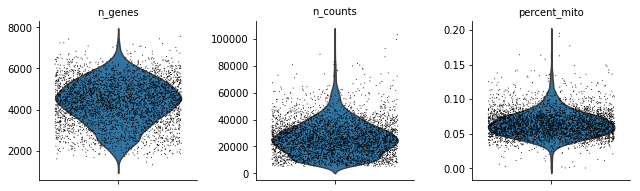

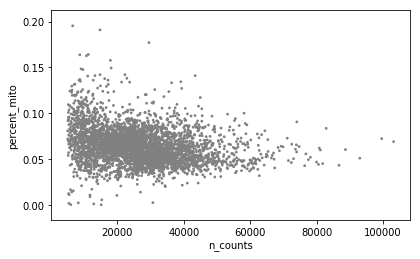

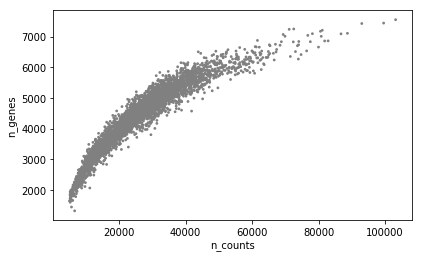

In [10]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)


mito_genes = adata.var_names.str.startswith('MT-') 
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1) 
adata.obs['n_counts'] = adata.X.sum(axis=1)


np.sum(adata[:, mito_genes].X, axis=1)

sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)


sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')



adata = adata[adata.obs['percent_mito'] < 0.05, :]


In [11]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
adata.raw = adata

Trying to set attribute `.obs` of view, making a copy.


In [12]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)


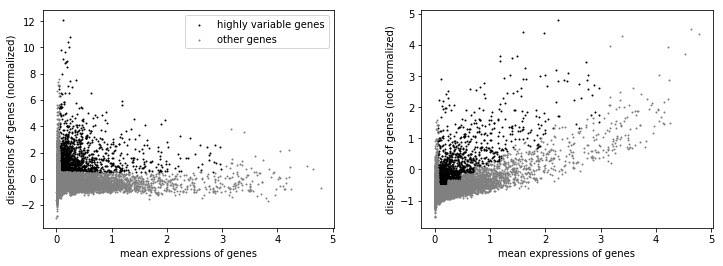

In [13]:
sc.pp.highly_variable_genes(adata, min_mean=0.05, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [14]:
adata = adata[:, adata.var['highly_variable']]

In [15]:
sc.pp.regress_out(adata, ['S_score', 'G2M_score','n_counts', 'percent_mito'])
sc.pp.scale(adata, max_value=10) #i geni con una varianza più alta di 10 gli viene attribuita varianza uguale a 10

Trying to set attribute `.obs` of view, making a copy.
... storing 'phase' as categorical


#### 1b) PCA egrafico UMAP

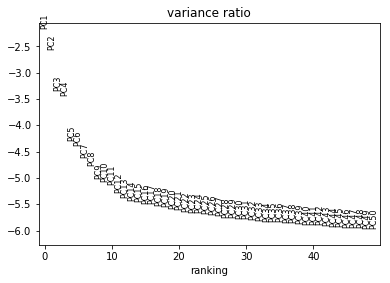

In [16]:
sc.tl.pca(adata, svd_solver='arpack')

sc.pl.pca_variance_ratio(adata, log=True,n_pcs=50)

In [17]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

In [18]:
sc.tl.umap(adata) 

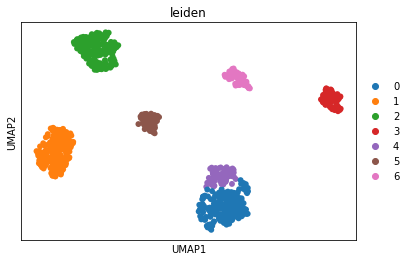

In [19]:
sc.tl.leiden(adata, resolution=0.3)
sc.pl.umap(adata, color="leiden")

In [20]:
adata.write('adata_10x/adata_sc_10x.h5ad')

#### 1c) ora do i nomi ai cluster

In [21]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')

In [22]:
df_significativo= pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20) #### df con i 20 geni significativi per gruppo

In [20]:
df_significativo.head()

,0,1,2,3,4,5,6
0,CD74,SEC61G,GAGE12D,MT1E,XAGE1B,AKR1B10,RPS28P7
1,LCN2,RPL7P9,GAGE12E,LGALS1,MMP7,KRT81,RPS15
2,SAA1,CDKN2A,GAGE12G,DHRS2,TMSB4X,AKR1C2,XAGE1B
3,CXCL1,RPL7,GAGE2E,PEG10,CXCL6,ALDH1A1,AC007969.1
4,HLA-B,CHCHD2,GAGE2A,RPS5,RAC1,AKR1C3,LGALS1


###### siccome ci vengono 7 gruppi ma dovrebbero esserci solo 5 linee cellulari, controllo tramite enrichr che a quale gruppo appartenga la linea

In [21]:
for x in df_significativo.loc[:,'5']:
    print(x) #sono le a549

AKR1B10
KRT81
AKR1C2
ALDH1A1
AKR1C3
RPS16
GPX2
FTL
AKR1C1
RPS19
KRT18
KRT8
KRT18P17
G6PD
AGR2
PCBD1
PON2
S100A4
TKT
COX6B1


In [23]:
cell_annotation= pd.read_table('../sc_mixology/data/csv/sc_10x_5cl.metadata.csv.gz', compression="gzip", sep=",", index_col=0)

In [24]:
cell_annotation.head()

,unaligned,aligned_unmapped,mapped_to_exon,mapped_to_intron,ambiguous_mapping,mapped_to_ERCC,mapped_to_MT,number_of_genes,total_count_per_cell,non_mt_percent,...,pct_counts_in_top_500_features,total_features,log10_total_features,pct_counts_top_50_features,pct_counts_top_100_features,pct_counts_top_200_features,pct_counts_top_500_features,cell_line,cell_line_demuxlet,demuxlet_cls
Lib90_00000,22485,2861,129248,10666,5503,0,9095,8344,104055,0.801874,...,67.118351,8344,3.921426,27.307674,39.538705,52.677911,67.118351,HCC827,HCC827,SNG
Lib90_00001,20325,2383,124178,11106,5308,0,9170,8216,100421,0.802860,...,68.047520,8216,3.914713,27.729260,40.342160,53.850290,68.047520,HCC827,HCC827,DBL
Lib90_00002,19279,2732,116260,9561,5064,0,6044,8121,93744,0.799806,...,61.432198,8121,3.909663,21.509643,32.380739,45.084485,61.432198,H838,H838,SNG
Lib90_00003,18580,2575,109675,11012,4764,0,6806,7809,89426,0.814897,...,71.056516,7809,3.892651,29.270011,43.419140,57.277526,71.056516,HCC827,HCC827,SNG
Lib90_00004,17759,2067,108807,9501,4809,0,4794,7807,87517,0.813591,...,67.645143,7807,3.892540,26.262326,39.047271,52.941714,67.645143,HCC827,HCC827,SNG


In [25]:
adata.obs.loc[:, "cell_line"] = cell_annotation.loc[adata.obs_names, "cell_line"]
adata.obs.columns

Index(['n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase',
       'leiden', 'cell_line'],
      dtype='object')

In [26]:
adata.obs.loc[:, "cell_line_demuxlet"] = cell_annotation.loc[adata.obs_names, "cell_line_demuxlet"]
adata.obs.columns

Index(['n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase',
       'leiden', 'cell_line', 'cell_line_demuxlet'],
      dtype='object')

... storing 'cell_line' as categorical
... storing 'cell_line_demuxlet' as categorical


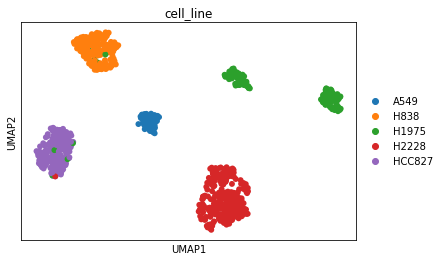

In [27]:
%matplotlib inline
sc.pl.umap(adata, color="cell_line")

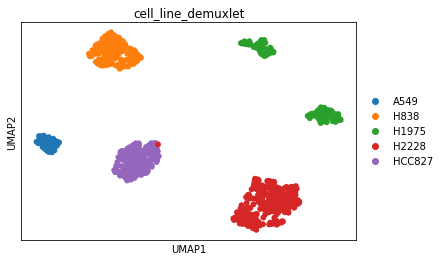

In [27]:
%matplotlib inline
sc.pl.umap(adata, color="cell_line_demuxlet")

In [28]:
adata.write('adata_10x/adata_sc_10x.h5ad')

## 2) Grafi: Graph tool (per esercizio, lo uso meglio dopo)

In [28]:
import graph_tool.all as gt

In [29]:
g = gt.Graph(directed=False)

In [30]:
adata.uns['neighbors']

{'params': {'n_neighbors': 10,
  'method': 'umap',
  'metric': 'euclidean',
  'n_pcs': 40},
 'distances': <860x860 sparse matrix of type '<class 'numpy.float64'>'
 	with 7740 stored elements in Compressed Sparse Row format>,
 'connectivities': <860x860 sparse matrix of type '<class 'numpy.float64'>'
 	with 12014 stored elements in Compressed Sparse Row format>}

In [31]:
adj=adata.uns['neighbors']['connectivities']
w_adj=adata.uns['neighbors']['distances']

In [103]:
edge_weights = g.new_edge_property('double')
g.edge_properties['weight'] = edge_weights
nnz = np.nonzero(np.triu(adj.todense(),1))
nedges = len(nnz[0])
g.add_edge_list(np.hstack([np.transpose(nnz),np.reshape(adj[nnz],(nedges,1))]),eprops=[edge_weights])

In [104]:
w_adj = w_adj /w_adj.max()
w_adj = 1 - w_adj.todense()

In [105]:
wg = gt.Graph(directed=False)
edge_weights = wg.new_edge_property('double')
wg.edge_properties['weight'] = edge_weights
nnz = np.nonzero(np.triu(w_adj,1))
nedges = len(nnz[0])
wg.add_edge_list(np.hstack([np.transpose(nnz),np.reshape(adj[nnz],(nedges,1))]),eprops=[edge_weights])

##### non-nested SBM

In [106]:
state = gt.minimize_blockmodel_dl(g)

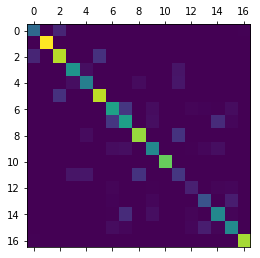

In [107]:
e= state.get_matrix()

matshow(e.todense())
#savefig("...")

##### Nested SBM

In [108]:
n_state = gt.minimize_nested_blockmodel_dl(g)

In [38]:
n_state.print_summary()

l: 0, N: 860, B: 50
l: 1, N: 50, B: 13
l: 2, N: 13, B: 4
l: 3, N: 4, B: 2
l: 4, N: 2, B: 1


In [39]:
levels = n_state.get_levels()
for s in levels:
    print(s)

<BlockState object with 50 blocks (50 nonempty), degree-corrected, for graph <Graph object, undirected, with 860 vertices and 5967 edges at 0x7f83460a0e90>, at 0x7f834793e150>
<BlockState object with 13 blocks (13 nonempty), for graph <Graph object, undirected, with 50 vertices and 248 edges at 0x7f8324e37c10>, at 0x7f8324e4c650>
<BlockState object with 4 blocks (4 nonempty), for graph <Graph object, undirected, with 13 vertices and 34 edges at 0x7f8324ea4490>, at 0x7f8324ea9990>
<BlockState object with 2 blocks (2 nonempty), for graph <Graph object, undirected, with 4 vertices and 7 edges at 0x7f8324ea4250>, at 0x7f8324e34210>
<BlockState object with 1 blocks (1 nonempty), for graph <Graph object, undirected, with 2 vertices and 3 edges at 0x7f8324df4110>, at 0x7f8324eb1250>


##### Model selection

In [40]:
state_ndc = gt.minimize_nested_blockmodel_dl(g, deg_corr=False)
state_dc  = gt.minimize_nested_blockmodel_dl(g, deg_corr=True)

print("Non-degree-corrected DL:\t", state_ndc.entropy())
print("Degree-corrected DL:\t", state_dc.entropy())

Non-degree-corrected DL:	 19522.996868517705
Degree-corrected DL:	 19946.370793301725


In [41]:
print(u"ln \u039b: ", state_dc.entropy() - state_ndc.entropy()) # sembra essere migliore la ndc

ln Λ:  423.37392478402035


In [109]:
n_state = gt.minimize_nested_blockmodel_dl(g, deg_corr=False)

In [117]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(n_state.project_level(2).get_blocks()))

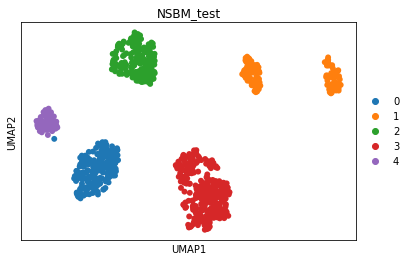

In [120]:
sc.pl.umap(adata, color="NSBM_test")

In [119]:
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

cell_line,A549,H838,H1975,H2228,HCC827
NSBM_test,,,,,
0,1,0,4,1,188
1,0,0,127,0,0
2,0,176,7,0,0
3,0,0,0,295,0
4,61,0,0,0,0


## 3) Paga
#### 3a) innanzitutto provo il Paga senza nessuna informazione

In [28]:
sc.tl.diffmap(adata)

sc.pp.neighbors(adata, n_neighbors=10)#, use_rep='X_diffmap')

In [29]:
sc.tl.leiden(adata, resolution=0.2)

In [30]:
sc.tl.paga(adata, groups='leiden')

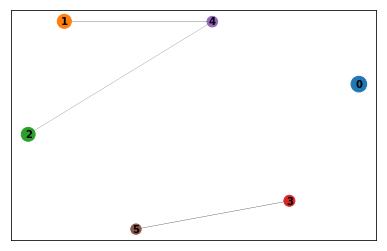

In [31]:
sc.pl.paga(adata, color=['leiden'])

In [32]:
adata.obs['leiden'].cat.categories

Index(['0', '1', '2', '3', '4', '5'], dtype='object')

In [33]:
adata.obs.columns

Index(['n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase',
       'leiden', 'cell_line', 'cell_line_demuxlet'],
      dtype='object')

#### 3b) istruisco il Paga con le cell lines

In [34]:
adata.obs['cell_line'].cat.categories

Index(['A549', 'H838', 'H1975', 'H2228', 'HCC827'], dtype='object')

In [35]:
sc.tl.paga(adata, groups='cell_line')

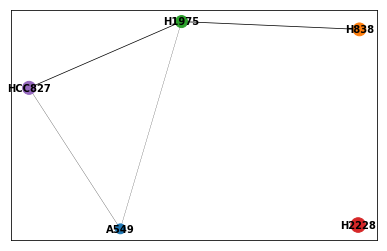

In [36]:
sc.pl.paga(adata, random_state=3124)

In [37]:
sc.tl.paga(adata, groups='cell_line_demuxlet')

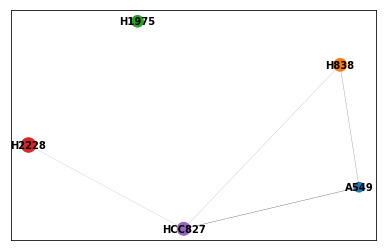

In [38]:
sc.pl.paga(adata, random_state=8)

#### 3c) provo a fare la computazione inizializzando con il Paga

In [39]:
sc.tl.draw_graph(adata, init_pos='paga')

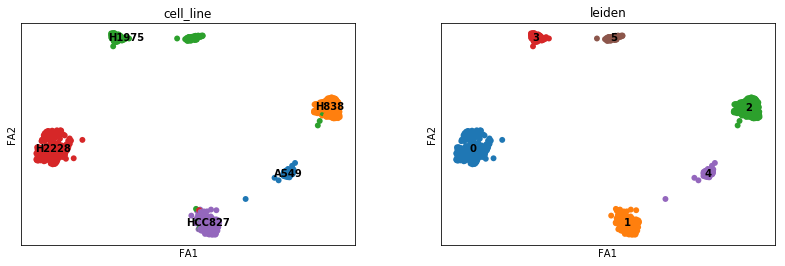

In [40]:
sc.pl.draw_graph(adata, color=['cell_line', 'leiden'], legend_loc='on data')

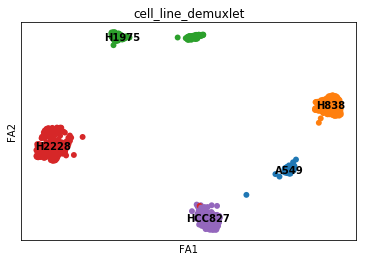

In [41]:
sc.pl.draw_graph(adata, color=['cell_line_demuxlet'], legend_loc='on data')

In [49]:
adata.write('paga_10x.h5ad')

## 4) Valutazione leiden/luvain vs. SBM

### 4a) leiden vs SBM: la valutazione di leiden

In [42]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

In [43]:
sc.tl.umap(adata) 

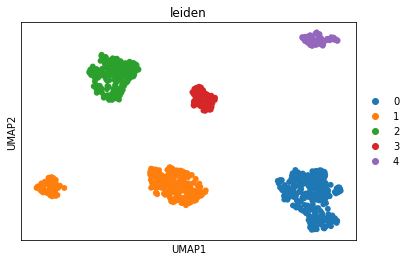

In [44]:
sc.tl.leiden(adata, resolution=0.025)
sc.pl.umap(adata, color="leiden") #nonostante cambi ogni risoluzione, leiden fa 5 gruppi ma sbaglia, ne classifica male due

##### itero le risoluzioni di leiden per trovare il range migliore in cui leiden riconosca 5 gruppi

In [45]:
resolutions = np.arange(0, 1, 0.005)
leiden_clusters = pd.DataFrame(index=adata.obs_names, columns=resolutions)

In [46]:
for r in resolutions:
    sc.tl.leiden(adata, resolution=r)
    leiden_clusters.loc[:, r] = adata.obs.leiden

In [47]:
leiden_clusters.to_csv('adata_10x/10x_leiden_clusters.csv')

#### 4a.I) ho selezionato il modello di nested SBM non-degree corrected: lo valuto

In [1]:
import graph_tool.all as gt
g = gt.Graph(directed=False)

/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/graph_tool/all.py:40: RuntimeWarning: Error importing draw module, proceeding nevertheless: /usr/lib/python3/dist-packages/cairo/_cairo.cpython-37m-x86_64-linux-gnu.so: undefined symbol: cairo_tee_surface_index
  warnings.warn(msg, RuntimeWarning)


In [32]:
adj=adata.uns['neighbors']['connectivities']
w_adj=adata.uns['neighbors']['distances']

In [33]:
edge_weights = g.new_edge_property('double')
g.edge_properties['weight'] = edge_weights
nnz = np.nonzero(np.triu(adj.todense(),1))
nedges = len(nnz[0])
g.add_edge_list(np.hstack([np.transpose(nnz),np.reshape(adj[nnz],(nedges,1))]),eprops=[edge_weights])

In [34]:
w_adj = w_adj /w_adj.max()
w_adj = 1 - w_adj.todense()

In [35]:
wg = gt.Graph(directed=False)
edge_weights = wg.new_edge_property('double')
wg.edge_properties['weight'] = edge_weights
nnz = np.nonzero(np.triu(w_adj,1))
nedges = len(nnz[0])
wg.add_edge_list(np.hstack([np.transpose(nnz),np.reshape(adj[nnz],(nedges,1))]),eprops=[edge_weights])

In [37]:
pickle.dump(wg, open("adata_10x/10x_weighted_graph_wg.pkl", "wb"), 2)

In [32]:
pickle.dump(g, open("adata_10x/10x_graph_g.pkl", "wb"), 2)

In [33]:
g = pickle.load( open( "adata_10x/10x_graph_g.pkl", "rb" ) ) #ho gia il grafo caricato

In [53]:
n_state = gt.minimize_nested_blockmodel_dl(g, deg_corr=False)

In [133]:
pickle.dump(n_state, open("adata_10x/10x_nested_state.pkl", "wb"), 2)

In [33]:
n_state = pickle.load( open( "adata_10x/10x_nested_state.pkl", "rb" ) ) #ho gia il grafo caricato

In [34]:
n_state

<NestedBlockState object, with base <BlockState object with 63 blocks (63 nonempty), for graph <Graph object, undirected, with 860 vertices and 5996 edges at 0x7fee39f8cd50>, at 0x7fee397b7650>, and 5 levels of sizes [(860, 63), (63, 15), (15, 5), (5, 2), (2, 1)] at 0x7fee3a116c10>

In [35]:
n_state.print_summary()

l: 0, N: 860, B: 63
l: 1, N: 63, B: 15
l: 2, N: 15, B: 5
l: 3, N: 5, B: 2
l: 4, N: 2, B: 1


In [36]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(n_state.project_level(2).get_blocks()))

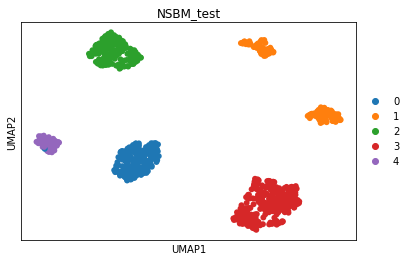

In [37]:
sc.pl.umap(adata, color="NSBM_test")

In [62]:
NSBM_clusters=pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)
print(NSBM_clusters)

cell_line  A549  H838  H1975  H2228  HCC827
NSBM_test                                  
0             1     0      4      1     188
1             0     0    127      0       0
2             0   176      7      0       0
3             0     0      0    295       0
4            61     0      0      0       0


In [78]:
NSBM_clusters.to_csv('adata_10x/10x_nsbm_clusters.csv')

#### 4a.II) mutual information: confronto leiden e SBM

In [53]:
import sklearn.metrics

##### mutua informazione tra sbm e adata

In [54]:
sklearn.metrics.adjusted_mutual_info_score( adata.obs.NSBM_test, adata.obs.cell_line)

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


0.9521213189358717

##### mutua informazione tra sbm e leiden (risoluzione 0.025)

In [55]:
sklearn.metrics.adjusted_mutual_info_score( adata.obs.NSBM_test, leiden_clusters.loc[:,0.025])

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


0.8907273147959685

##### mutua informazione leiden (r=0.025) e adata

In [56]:
sklearn.metrics.adjusted_mutual_info_score( adata.obs.cell_line, leiden_clusters.loc[:,0.025])

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


0.8471854700733557

##### qui faccio il grafico per paragonarne i profili

In [57]:
MI_= [sklearn.metrics.adjusted_mutual_info_score( adata.obs.NSBM_test, leiden_clusters.loc[:,x]) for x in resolutions]
RS= [sklearn.metrics.adjusted_rand_score( adata.obs.NSBM_test, leiden_clusters.loc[:,x]) for x in resolutions]
MI_cl= [sklearn.metrics.adjusted_mutual_info_score( adata.obs.cell_line, leiden_clusters.loc[:,x]) for x in resolutions]

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

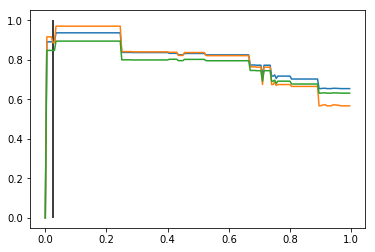

In [58]:
plot(resolutions, MI_)
plot(resolutions, RS)
plot(resolutions, MI_cl)
vlines(0.025, 0, 1)

##### vedo il profilo di mi di sbm

In [59]:
NSBM = np.array([list(n_state.project_level(x).get_blocks()) for x in range(5)])
NSBM

array([[ 0,  1,  1, ..., 49, 50,  9],
       [ 0,  1,  1, ...,  6, 14,  4],
       [ 0,  1,  1, ...,  3,  4,  2],
       [ 0,  1,  1, ...,  1,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])

In [60]:
MI_nsbm = [sklearn.metrics.adjusted_mutual_info_score( adata.obs.cell_line, NSBM[x]) for x in range(5)]

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

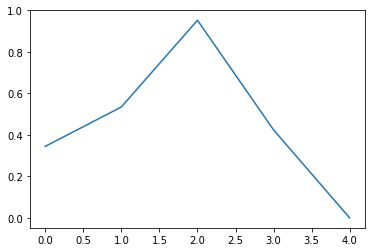

In [75]:
plot(range(5), MI_nsbm)

##### vedo che il gruppo 2 è quello che da una maggiore mutua informazione
#### 4a.III) dataframe leiden vs. sbm: paragone MI tra ogni risoluzione di leiden e i 5 livelli di NSBM

#### heatmap 5(sbm) x 200 (risoluzioni leiden da 0 a 1)

In [61]:
SBM_gruppi=pd.Categorical(adata.obs.NSBM_test).unique()
SBM_gruppi

[0, 1, 2, 3, 4]
Categories (5, int64): [0, 1, 2, 3, 4]

In [62]:
leiden_vs_SBM=pd.DataFrame(index=resolutions, columns=SBM_gruppi)

In [63]:
leiden_vs_SBM.head()

,0,1,2,3,4
0.000,NaN,NaN,NaN,NaN,NaN
0.005,NaN,NaN,NaN,NaN,NaN
0.010,NaN,NaN,NaN,NaN,NaN
0.015,NaN,NaN,NaN,NaN,NaN
0.020,NaN,NaN,NaN,NaN,NaN


#### MI tra le resolution di leiden e i livelli 0,1,2,3,4 di NSBM

In [64]:
MI_leiden_NSBM0= [sklearn.metrics.adjusted_mutual_info_score( NSBM[0], leiden_clusters.loc[:,x]) for x in resolutions]
MI_leiden_NSBM1= [sklearn.metrics.adjusted_mutual_info_score( NSBM[1], leiden_clusters.loc[:,x]) for x in resolutions]
MI_leiden_NSBM2= [sklearn.metrics.adjusted_mutual_info_score( NSBM[2], leiden_clusters.loc[:,x]) for x in resolutions]
MI_leiden_NSBM3= [sklearn.metrics.adjusted_mutual_info_score( NSBM[3], leiden_clusters.loc[:,x]) for x in resolutions]
MI_leiden_NSBM4= [sklearn.metrics.adjusted_mutual_info_score( NSBM[4], leiden_clusters.loc[:,x]) for x in resolutions]

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

#### ora devo mettere i valori di queste liste nel dataframe

In [65]:
leiden_vs_SBM.loc[:,0]=MI_leiden_NSBM0
leiden_vs_SBM.loc[:,1]=MI_leiden_NSBM1
leiden_vs_SBM.loc[:,2]=MI_leiden_NSBM2
leiden_vs_SBM.loc[:,3]=MI_leiden_NSBM3
leiden_vs_SBM.loc[:,4]=MI_leiden_NSBM4

In [66]:
MI_leiden_NSBM4[0:4]

[1.0, 1.44593652306206e-16, 1.44593652306206e-16, 1.44593652306206e-16]

In [67]:
leiden_vs_SBM.head()

,0,1,2,3,4
0.000,-5.46077e-17,-1.86179e-16,5.16431e-16,0,1
0.005,0.307877,0.500568,0.890904,0.516812,1.44594e-16
0.010,0.307877,0.500568,0.890904,0.516812,1.44594e-16
0.015,0.307877,0.500568,0.890904,0.516812,1.44594e-16
0.020,0.307877,0.500568,0.890904,0.516812,1.44594e-16


In [83]:
leiden_vs_SBM.to_csv('adata_10x/10x_mi_leiden_nsbm.csv')

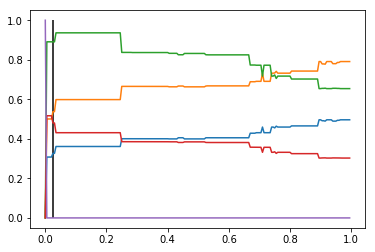

In [68]:
plot(leiden_vs_SBM)
vlines(0.025, 0, 1)

### 4b) louvain vs SBM

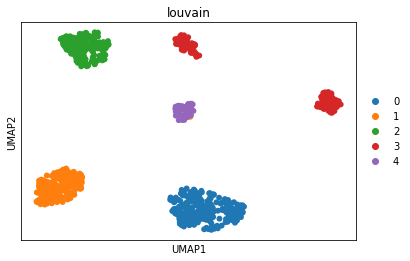

In [69]:
sc.tl.louvain(adata, resolution=0.045)
sc.pl.umap(adata, color="louvain") 

In [70]:
resolutions= np.arange(0, 1, 0.005)
louvain_clusters= pd.DataFrame(index=adata.obs_names, columns=resolutions)

In [71]:
for r in resolutions:
    sc.tl.louvain(adata, resolution=r)
    louvain_clusters.loc[:, r] = adata.obs.louvain

In [83]:
louvain_clusters.to_csv('adata_10x/10x_louvain_clusters.csv')

#### mutua informazione tra smb e louvain (r=0.045)

In [72]:
sklearn.metrics.adjusted_mutual_info_score( adata.obs.NSBM_test, louvain_clusters.loc[:,0.045])

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


1.0

#### mutua informazione louvain vs cell (r=0.045)

In [73]:
sklearn.metrics.adjusted_mutual_info_score( adata.obs.cell_line, louvain_clusters.loc[:,0.045])

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


0.9521213189358715

In [74]:
MI_= [sklearn.metrics.adjusted_mutual_info_score( adata.obs.NSBM_test, louvain_clusters.loc[:,x]) for x in resolutions]
RS= [sklearn.metrics.adjusted_rand_score( adata.obs.NSBM_test, louvain_clusters.loc[:,x]) for x in resolutions]
MI_cl= [sklearn.metrics.adjusted_mutual_info_score( adata.obs.cell_line, louvain_clusters.loc[:,x]) for x in resolutions]

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

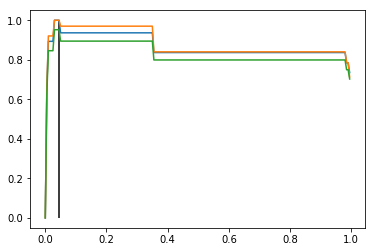

In [75]:
plot(resolutions, MI_)
plot(resolutions, RS)
plot(resolutions, MI_cl) #verde
vlines(0.045, 0, 1)

In [76]:
louvain_vs_SBM=pd.DataFrame(index=resolutions, columns=SBM_gruppi)

In [77]:
MI_louvain_NSBM0= [sklearn.metrics.adjusted_mutual_info_score( NSBM[0], louvain_clusters.loc[:,x]) for x in resolutions]
MI_louvain_NSBM1= [sklearn.metrics.adjusted_mutual_info_score( NSBM[1], louvain_clusters.loc[:,x]) for x in resolutions]
MI_louvain_NSBM2= [sklearn.metrics.adjusted_mutual_info_score( NSBM[2], louvain_clusters.loc[:,x]) for x in resolutions]
MI_louvain_NSBM3= [sklearn.metrics.adjusted_mutual_info_score( NSBM[3], louvain_clusters.loc[:,x]) for x in resolutions]
MI_louvain_NSBM4= [sklearn.metrics.adjusted_mutual_info_score( NSBM[4], louvain_clusters.loc[:,x]) for x in resolutions]

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

In [78]:
louvain_vs_SBM.loc[:,0]=MI_louvain_NSBM0
louvain_vs_SBM.loc[:,1]=MI_louvain_NSBM1
louvain_vs_SBM.loc[:,2]=MI_louvain_NSBM2
louvain_vs_SBM.loc[:,3]=MI_louvain_NSBM3
louvain_vs_SBM.loc[:,4]=MI_louvain_NSBM4

In [79]:
MI_louvain_NSBM4[0:5]

[1.0,
 7.81242578344332e-16,
 4.1243324338111497e-16,
 4.1243324338111497e-16,
 4.1243324338111497e-16]

In [96]:
louvain_vs_SBM.head()
imshow(louvain_vs_SBM, cmap=cm.Reds,vmin, vmax)

SyntaxError: positional argument follows keyword argument (<ipython-input-96-37d3d5b65982>, line 2)

In [97]:
louvain_vs_SBM.to_csv('adata_10x/10x_mi_louvain_nsbm.csv')

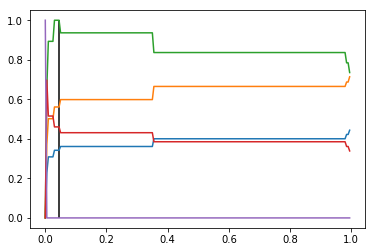

In [80]:
plot(louvain_vs_SBM)
vlines(0.045, 0, 1)

## 5) Sampling for the posterior distribution
### 5a) mcmc.equilibrate() per capire quanti blocchi sono più probabili per ogni livello

In [63]:
bs = n_state.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

In [64]:
state = n_state.copy(bs=bs, sampling=True)

In [65]:
dS, nattempts, nmoves = state.mcmc_sweep(niter=1000)

print("Change in description length:", dS)
print("Number of accepted vertex moves:", nmoves)

Change in description length: 3.370855939481963
Number of accepted vertex moves: 293566


In [84]:
gt.mcmc_equilibrate(state, wait=1000, mcmc_args=dict(niter=10))

(19586.101309986465, 38697388, 12254786)

In [132]:
pickle.dump(state, open("adata_10x/10x_equilibrate_state.pkl", "wb"), 2)

In [68]:
state = pickle.load( open( "adata_10x/10x_equilibrate_state.pkl", "rb" ) )

ora faccio una funzione (collect_info) che mi permette di collezionare 2 cose: da una parte la probabilità del numero dei blocchi in ogni livello (h:collect num_groups), dall'altra la probailità di ogni nodo di cadere in un gruppo in ogni livello (pv:collect_marginals)

In [ ]:
#collect_marginals
#pv = [None] * len(state.get_levels())

#def collect_marginals(s):
  # global pv
  # pv = [sl.collect_vertex_marginals(pv[l]) for l, sl in enumerate(s.get_levels())]

In [85]:
#collect_num_groups
#h = [np.zeros(g.num_vertices() + 1) for s in state.get_levels()]

#def collect_num_groups(s):
 #   for l, sl in enumerate(s.get_levels()):
  #     B = sl.get_nonempty_B()
   #    h[l][B] += 1

In [85]:
h = [np.zeros(g.num_vertices() + 1) for s in state.get_levels()]
pv = [None] * len(state.get_levels())


def collect_info(s):
    for l,sl in enumerate(s.get_levels()):
        B=sl.get_nonempty_B()
        h[l][B] +=1
        global pv
        pv=[sl.collect_vertex_marginals(pv[l]) for l, sl in enumerate(s.get_levels())]

In [86]:
gt.mcmc_equilibrate(state, force_niter=10000, mcmc_args=dict(niter=10),
                    callback=collect_info)

(19570.000987357784, 96255310, 30611649)

ora ho i marginals (pv) e i levels (h)

In [87]:
import pickle #per salvare la lista h come una variabile

In [88]:
pickle.dump(state, open('adata_10x/10x_equilibrate2_state.pkl', 'wb'), 2)

In [89]:
pickle.dump(pv, open('adata_10x/10x_marginals_probability.pkl', 'wb'), 2)

In [90]:
pickle.dump(h, open('adata_10x/10x_block_probability.pkl', 'wb'), 2)

In [69]:
state = pickle.load( open( "adata_10x/10x_equilibrate2_state.pkl", "rb" ) )

In [70]:
pv = pickle.load( open( "adata_10x/10x_marginals_probability.pkl", "rb" ) )

In [71]:
h = pickle.load( open( "adata_10x/10x_block_probability.pkl", "rb" ) )

In [92]:
state

<NestedBlockState object, with base <BlockState object with 68 blocks (63 nonempty), for graph <Graph object, undirected, with 860 vertices and 5996 edges at 0x7ff3af427dd0>, at 0x7ff3af773910>, and 10 levels of sizes [(860, 63), (63, 15), (15, 5), (5, 3), (3, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2)] at 0x7ff3af427150>

In [107]:
pv

[<VertexPropertyMap object with value type 'vector<int32_t>', for Graph 0x7ff3af427dd0, at 0x7ff3af1c7f50>,
 <VertexPropertyMap object with value type 'vector<int32_t>', for Graph 0x7ff3af7732d0, at 0x7ff3af1c76d0>,
 <VertexPropertyMap object with value type 'vector<int32_t>', for Graph 0x7ff3af7730d0, at 0x7ff3af1c70d0>,
 <VertexPropertyMap object with value type 'vector<int32_t>', for Graph 0x7ff3af562e90, at 0x7ff3af1c7310>,
 <VertexPropertyMap object with value type 'vector<int32_t>', for Graph 0x7ff3af3d7250, at 0x7ff3af1c7050>,
 <VertexPropertyMap object with value type 'vector<int32_t>', for Graph 0x7ff3afb66dd0, at 0x7ff3af1c72d0>,
 <VertexPropertyMap object with value type 'vector<int32_t>', for Graph 0x7ff3afb662d0, at 0x7ff3af1c7910>,
 <VertexPropertyMap object with value type 'vector<int32_t>', for Graph 0x7ff3af6b2d90, at 0x7ff3af3f1910>,
 <VertexPropertyMap object with value type 'vector<int32_t>', for Graph 0x7ff3af6ce3d0, at 0x7ff3af3f1810>,
 <VertexPropertyMap object w

<BarContainer object of 5 artists>

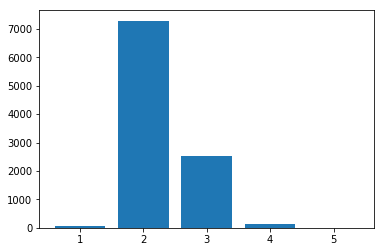

In [104]:
l = 7
idxs = np.where(h[l] > 0)[0]
v = h[l][idxs]
bar(idxs, v)

In [ ]:
s=state.get_levels()[3]

In [ ]:
pp = None
s.collect_vertex_marginals(pp)

### 5b) Model class selection: selezionare il modello migliore in base all'entropia del grafo e alla sua description length

In [89]:
nL = 10

for deg_corr in [True, False]:
    state = gt.minimize_nested_blockmodel_dl(g, deg_corr=deg_corr) 

In [90]:
bs = state.get_bs()                     
bs += [np.zeros(1)] * (nL - len(bs))

In [91]:
state = state.copy(bs=bs, sampling=True)

In [92]:
dls = []                               # description length histo
vm = [None] * len(state.get_levels())  # vertex marginals
em = None                              # edge marginals

In [93]:
def collect_marginals(s):
    global vm, em
    levels = s.get_levels()
    vm = [sl.collect_vertex_marginals(vm[l]) for l, sl in enumerate(levels)]
    em = levels[0].collect_edge_marginals(em)
    dls.append(s.entropy())

In [94]:
gt.mcmc_equilibrate(state, force_niter=20000, mcmc_args=dict(niter=10), callback=collect_marginals)

(19587.72347577117, 192594146, 60750847)

In [95]:
S_mf = [gt.mf_entropy(sl.g, vm[l]) for l, sl in enumerate(state.get_levels())]
S_bethe = gt.bethe_entropy(g, em)[0]
L = -mean(dls)

print("Model evidence for deg_corr = %s:" % deg_corr, L + sum(S_mf), "(mean field),", L + S_bethe + sum(S_mf[1:]), "(Bethe)")


Model evidence for deg_corr = False: -18971.763154807402 (mean field), -19282.03496654176 (Bethe)


In [147]:
type(adata)

anndata.core.anndata.AnnData

In [48]:
type(n_state)

graph_tool.inference.nested_blockmodel.NestedBlockState

In [97]:
state.collect_partition_histogram(h=h, update=1)

ArgumentError: Python argument types in
    graph_tool.inference.libgraph_tool_inference.collect_hierarchical_partitions(list, list, int)
did not match C++ signature:
    collect_hierarchical_partitions(boost::python::api::object, PartitionHist {lvalue}, unsigned long, bool)

## 6) comprensione del grafo

#### Variazione di len bs

In [39]:
BS=[]
for i in range(10,30):
    bs = n_state.get_bs()                   
    bs += [np.zeros(1)] * (i - len(bs))
    BS.append(bs)